**CLUSTER BIG DATA (HADOOP + SPARK) - DOCKER IMAGES**

**Instalação do Docker, Docker-compose e Repositório de Imagens:**

Docker: https://docs.docker.com/get-docker/ 

Docker-compose: https://docs.docker.com/compose/install/

Docker-HUB: https://hub.docker.com/



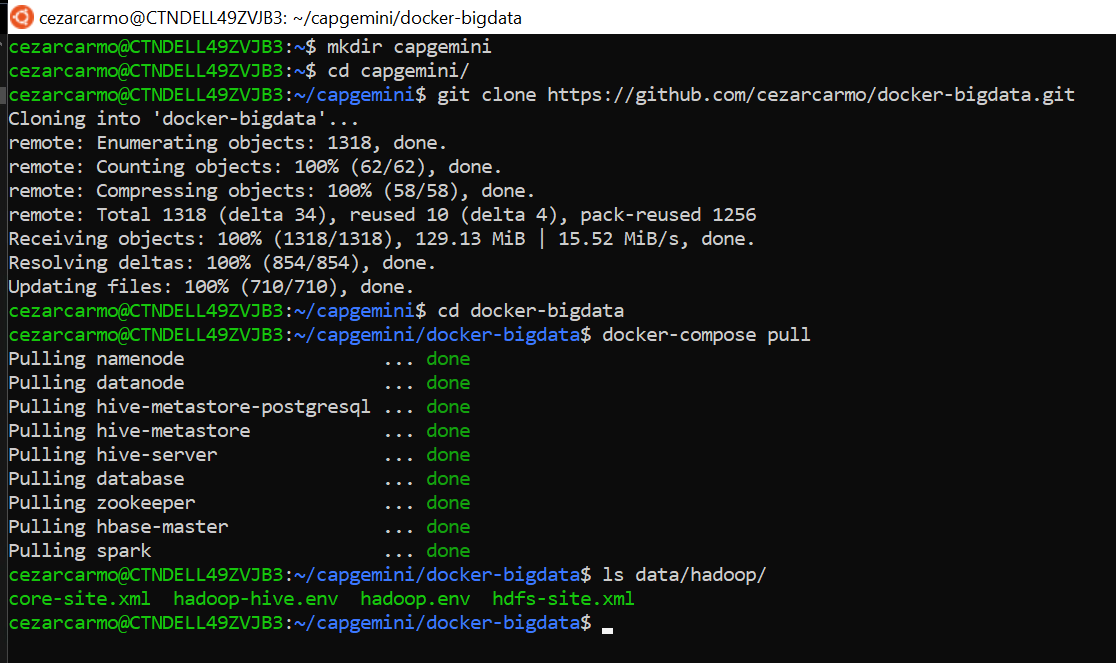

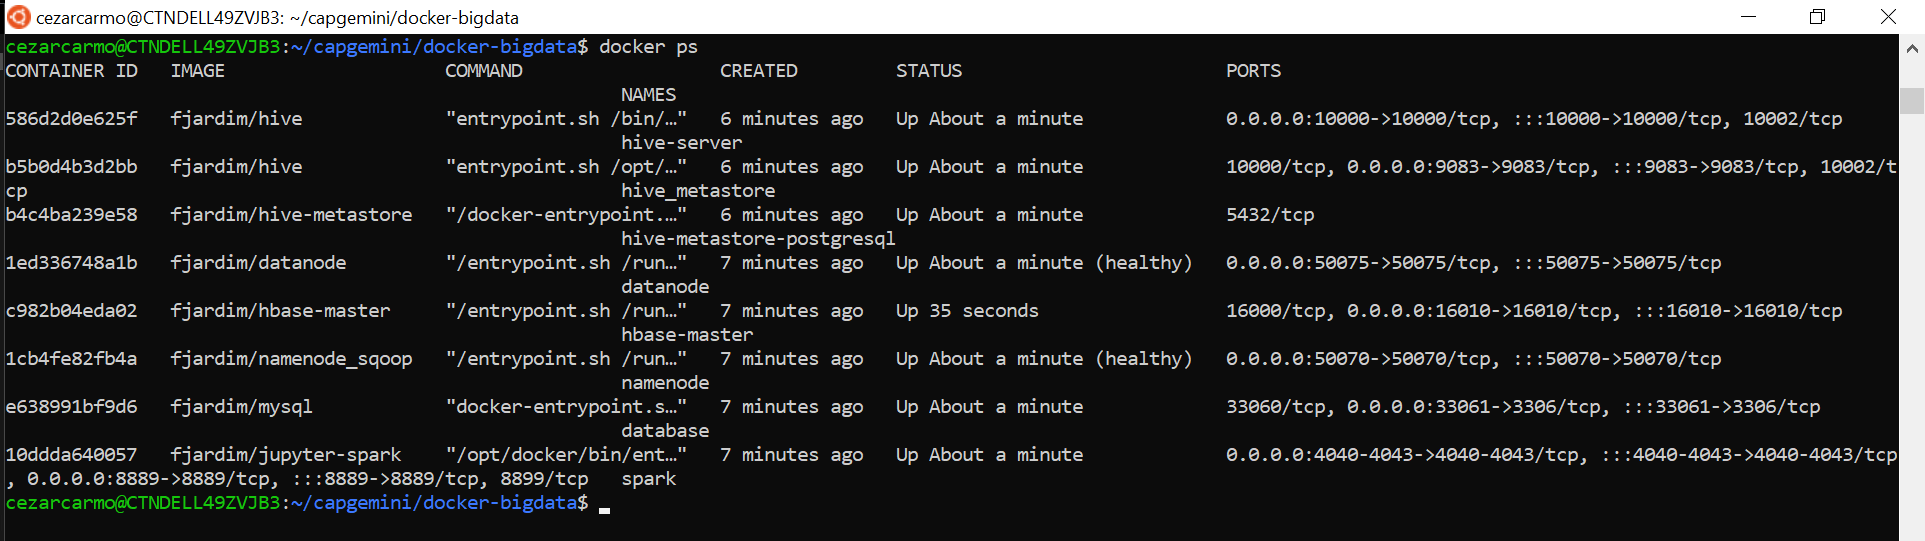

**docker-compose.yaml**

In [ ]:
version: '3' 
services:

  namenode:
    image: fjardim/namenode_sqoop
    container_name: namenode
    hostname: namenode
    volumes:
      - ./data/hdfs/namenode:/hadoop/dfs/name
      - ./input:/input
    environment:
      - CLUSTER_NAME=test
    env_file:
      - ./data/hadoop/hadoop-hive.env
    ports:
      - "50070:50070"
    deploy:
      resources:
        limits:
          memory: 500m
  
  datanode:
    image: fjardim/datanode
    container_name: datanode
    hostname: datanode
    volumes:
      - ./data/hdfs/datanode:/hadoop/dfs/data
      #- ./data/hadoop/bank:/bank
    env_file:
      - ./data/hadoop/hadoop-hive.env
    environment:
      SERVICE_PRECONDITION: "namenode:50070"
    depends_on:
      - namenode
    ports:
      - "50075:50075"
    deploy:
      resources:
        limits:
          memory: 500m
  
  hive-server:
    image: fjardim/hive
    container_name: hive-server
    hostname: hive_server
    env_file:
      - ./data/hadoop/hadoop-hive.env
    environment:
      HIVE_CORE_CONF_javax_jdo_option_ConnectionURL: "jdbc:postgresql://hive-metastore/metastore"
      SERVICE_PRECONDITION: "hive-metastore:9083"
    ports:
      - "10000:10000"
    depends_on:
      - hive-metastore
    deploy:
      resources:
        limits:
          memory: 500m
  
  hive-metastore:
    image: fjardim/hive
    container_name: hive_metastore
    hostname: hive_metastore
    env_file:
      - ./data/hadoop/hadoop-hive.env
    command: /opt/hive/bin/hive --service metastore
    environment:
      SERVICE_PRECONDITION: "namenode:50070 datanode:50075 hive-metastore-postgresql:5432"
    ports:
      - "9083:9083"
    depends_on:
      - hive-metastore-postgresql
    deploy:
      resources:
        limits:
          memory: 500m
  
  hive-metastore-postgresql:
    image: fjardim/hive-metastore
    container_name: hive-metastore-postgresql
    hostname: hive_metastore_postgresql
    volumes:
      - ./data/postgresql:/var/lib/postgresql/data
    depends_on:
      - datanode
    deploy:
      resources:
        limits:
          memory: 500m

  hue:
    image: fjardim/hue
    hostname: hue
    container_name: hue
    dns: 8.8.8.8
    ports:
    - "8888:8888"
    volumes:
      - ./data/hue/hue-overrides.ini:/usr/share/hue/desktop/conf/z-hue.ini
    depends_on:
      - "database"
    deploy:
      resources:
        limits:
          memory: 500m
  
  database:
    image: fjardim/mysql
    container_name: database
    hostname: database
    ports:
        - "33061:3306"
    deploy:
      resources:
        limits:
          memory: 500m
    command: mysqld --innodb-flush-method=O_DSYNC --innodb-use-native-aio=OFF --init-file /data/application/init.sql
    volumes:
        - ./data/mysql/data:/var/lib/mysql
        - ./data/mysql/init.sql:/data/application/init.sql
    environment:
        MYSQL_ROOT_USER: root
        MYSQL_ROOT_PASSWORD: secret
        MYSQL_DATABASE: hue
        MYSQL_USER: root
        MYSQL_PASSWORD: secret

  zookeeper:
    image: fjardim/zookeeper
    container_name: zookeeper
    hostname: zookeeper
    ports:
      - "2181:2181"
    volumes:
      - ./data/zookeeper:/opt/zookeeper-3.4.6/data
    deploy:
      resources:
        limits:
          memory: 500m

  kafka:
    image: fjardim/kafka
    container_name: kafka
    hostname: kafka
    ports:
      - "9092:9092"
    volumes:
      - ./data/kafka:/kafka/kafka-logs-kafka
    depends_on:
      - zookeeper
    environment:
      KAFKA_ADVERTISED_HOST_NAME: kafka
      KAFKA_ZOOKEEPER_CONNECT: zookeeper:2181
    deploy:
      resources:
        limits:
          memory: 500m

  presto-coordinator:
    image: fjardim/prestodb
    container_name: presto
    hostname: presto
    ports:
      - "8080:8080"
    depends_on:
      - hive-server  
    deploy:
      resources:
        limits:
          memory: 500m

  hbase-master:
    image: fjardim/hbase-master
    container_name: hbase-master
    hostname: hbase-master
    env_file:
      - ./data/hbase/hbase-standalone.env
    environment:
      SERVICE_PRECONDITION: "namenode:50070 datanode:50075 zookeeper:2181"
    ports:
      - 16010:16010
    depends_on:
      - namenode
    deploy:
      resources:
        limits:
          memory: 500m
  
  mongo:
    image: fjardim/mongo
    container_name: mongo
    hostname: mongo
    restart: always
    environment:
      MONGO_INITDB_ROOT_USERNAME: root
      MONGO_INITDB_ROOT_PASSWORD: root
    ports:
      - 27017:27017
    volumes:
      - ./data/mongo:/data
    deploy:
      resources:
        limits:
          memory: 500m
 
  mongo-express:
    image: fjardim/mongo-express
    container_name: mongo_express
    hostname: mongo_express
    restart: always
    ports:
      - 8081:8081
    environment:
      ME_CONFIG_MONGODB_ADMINUSERNAME: root
      ME_CONFIG_MONGODB_ADMINPASSWORD: root
      ME_CONFIG_MONGODB_SERVER: mongo
    deploy:
      resources:
        limits:
          memory: 200m
 
  kafkamanager:
    image: fjardim/kafkamanager
    container_name: kafkamanager
    hostname: kafkamanager
    environment: 
      ZK_HOSTS: zookeeper:2181
    ports:
      - 9000:9000
    depends_on:
      - kafka
    deploy:
      resources:
        limits:
          memory: 200m
 
  metabase:
    image: fjardim/metabase
    container_name: metabase
    hostname: metabase
    volumes:
      - ./data/metabase/data:/metabase-data
    environment:
      MB_DB_FILE: "/metabase-data/metabase.db"
    ports:
      - 3000:3000
    deploy:
      resources:
        limits:
          memory: 500m
 
  nifi:
    image: fjardim/nifi
    container_name: nifi
    hostname: nifi
    volumes:
      - ./data/nifi:/opt/nifi/nifi-current/flowfile_repository
      - ./data/util:/util
    environment:
      NIFI_WEB_HTTP_PORT: "9090"
    ports:
      - "9090:9090"
      - "8443:8443"
    deploy:
      resources:
        limits:
          memory: 500m

  jupyter-spark:
    image: fjardim/jupyter-spark
    hostname: jupyter-spark
    container_name: jupyter-spark
    command: notebook
    env_file:
      - ./data/jupyter/jupyter.env
    ports:
      - 8889:8889
      - 4040:4040
      - 4041:4041
      - 4042:4042
      - 4043:4043
    volumes:
       - ./data/notebooks:/mnt/notebooks/
    environment:
       SPARK_MASTER: local[*]
       JUPYTER_PORT: 8889
    deploy:
      resources:
        limits:
          memory: 1g

**CÉZAR AUGUSTO MEIRA CARMO - cezaraugustomeiracarmo@gmail.com**